In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
from skorch.callbacks import EpochScoring
from sklearn.preprocessing import StandardScaler
from skorch import NeuralNetRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from scipy.stats import uniform, randint, loguniform

In [19]:
data = pd.read_csv("./train.csv")

spectrum = data.iloc[:, 6:]

#spectrum_filtered = pd.DataFrame(savgol_filter(spectrum, 7, 3, deriv = 2, axis = 0))
#spectrum_filtered_st = zscore(spectrum_filtered, axis = 1)

X = spectrum
y = data["PURITY"]

# Standardize the data before applying PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Appliquer PCA pour réduire la dimensionnalité
pca = PCA(n_components=118)
X_pca = pca.fit_transform(X_scaled)


X_train, X_valid, y_train, y_valid = train_test_split(X_pca, y, test_size=0.2, random_state=42)

standardizer = StandardScaler()
X_train_standardized = standardizer.fit_transform(X_train)
X_valid_standardized = standardizer.transform(X_valid)

X_train_tensor = torch.tensor(X_train_standardized, dtype=torch.float32).clone().detach()
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1).clone().detach()
X_valid_tensor = torch.tensor(X_valid_standardized, dtype=torch.float32).clone().detach()
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32).reshape(-1, 1).clone().detach()

In [27]:

# Définir le modèle de réseau de neurones simple
class SimpleNN(nn.Module):
    def __init__(self, input_size, fc1_out_features=100, fc2_out_features=64, dropout_rate=0.5):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, fc1_out_features)
        self.bn1 = nn.BatchNorm1d(fc1_out_features)  # Batch normalization
        self.fc2 = nn.Linear(fc1_out_features, fc2_out_features)
        self.bn2 = nn.BatchNorm1d(fc2_out_features)
        self.fc3 = nn.Linear(fc2_out_features, 1)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        x = F.silu(self.fc1(x))
        x = self.dropout(x)
        x = F.silu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Définir la classe NeuralNetRegressor
class NeuralNetRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, input_size, eta=0.001, max_epochs=100, fc1_out_features=50, fc2_out_features=1, batch=10, dropout_rate=0.5):
        self.input_size = input_size
        self.eta = eta
        self.max_epochs = max_epochs
        self.fc1_out_features = fc1_out_features
        self.fc2_out_features = fc2_out_features
        self.batch = batch
        self.dropout_rate = dropout_rate
        self.model = SimpleNN(input_size, fc1_out_features, fc2_out_features)
        self.criterion = nn.MSELoss()
    
    def fit(self, X, y):
        optimizer = optim.RMSprop(self.model.parameters(), lr=self.eta)
        X_tensor = X.clone().detach().float()
        y_tensor = y.clone().detach().float()
        for epoch in range(self.max_epochs):
            self.model.train()
            optimizer.zero_grad()
            outputs = self.model(X_tensor)
            loss = self.criterion(outputs, y_tensor)
            loss.backward()
            optimizer.step()
        return self
    
    def predict(self, X):
        self.model.eval()
        X_tensor = X.clone().detach().float()
        with torch.no_grad():
            outputs = self.model(X_tensor)
        return outputs.numpy()
    
    def parameters(self):
        return self.model.parameters()

# Initialiser le modèle
input_size = X_train_tensor.shape[1]
net = NeuralNetRegressor(input_size=input_size)

In [ ]:
####### TESTER LE MODELE #######

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

class SimpleNN(nn.Module):
    def __init__(self, input_size, fc1_out_features, fc2_out_features, dropout_rate):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, fc1_out_features)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(fc1_out_features, fc2_out_features)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(fc2_out_features, 1)

    def forward(self, x):
        x = F.silu(self.fc1(x))
        x = self.dropout1(x)
        x = F.silu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

class NeuralNetRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, input_size, eta=0.001, max_epochs=100, fc1_out_features=50, fc2_out_features=1, batch=10, dropout_rate=0.5,l2_lambda = 0.001, patience=20):
        self.input_size = input_size
        self.eta = eta
        self.max_epochs = max_epochs
        self.fc1_out_features = fc1_out_features
        self.fc2_out_features = fc2_out_features
        self.batch = batch
        self.dropout_rate = dropout_rate
        self.l2_lambda = l2_lambda
        self.patience = patience
        self.model = SimpleNN(input_size, fc1_out_features, fc2_out_features,dropout_rate)
        self.criterion = nn.MSELoss()
    
    def fit(self, X, y):
        optimizer = optim.Adam(self.model.parameters(), lr=self.eta, weight_decay=self.l2_lambda)
        X_train_tensor = torch.tensor(X_train_standardized, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
        X_valid_tensor = torch.tensor(X_valid_standardized, dtype=torch.float32)
        y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32).reshape(-1, 1)
        
        train_data = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_data, batch_size=self.batch, shuffle=True)
        
        best_loss = float('inf')
        patience_counter = 0
        
        train_losses = []
        val_losses = []
        
        for epoch in range(self.max_epochs):
            self.model.train()
            epoch_loss = 0
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                outputs = self.model(X_batch)
                loss = self.criterion(outputs, y_batch)
                l2_reg = torch.tensor(0., requires_grad=True)
                for param in self.model.parameters():
                    l2_reg = l2_reg + torch.norm(param, 2)
                loss = loss + self.l2_lambda * l2_reg
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                
            epoch_loss /= len(train_loader)
            train_losses.append(epoch_loss)
            
            # Validation
            self.model.eval()
            with torch.no_grad():
                val_outputs = self.model(X_valid_tensor)
                val_loss = self.criterion(val_outputs, y_valid_tensor)
                val_losses.append(val_loss)
                
                if val_loss < best_loss:
                    best_loss = val_loss
                    patience_counter = 0
                    torch.save(self.model.state_dict(), 'best_model.pth')
                else:
                    patience_counter += 1
                
                if patience_counter >= self.patience:
                    print(f"Early stopping at epoch {epoch}")
                    break
                
            
    def predict(self, X):
        # Prédiction avec le modèle entraîné
        X_tensor = torch.tensor(X, dtype=torch.float32).clone().detach()
        self.model.eval()
        with torch.no_grad():
            predictions = self.model(X_tensor)
        return predictions.numpy()

    def evaluate(self, X_train, y_train, X_valid, y_valid):
         # Obtenir les prédictions du modèle
        self.model.eval()
        with torch.no_grad():
            y_pred = self.model(X_valid).detach().numpy()  # Prédictions sur validation
            y_pred_train = self.model(X_train).detach().numpy()  # Prédictions sur entraînement

        predictions_tensor = torch.tensor(y_pred, dtype=torch.float32)
        predictions_tensor_train = torch.tensor(y_pred_train, dtype=torch.float32)

        # Calculer la MSE
        mse = torch.mean((predictions_tensor - y_valid_tensor)**2).item()

        # Calculer le t-score (la proportion des prédictions proches des vraies valeurs)
        t_score_test = torch.mean((torch.abs(predictions_tensor - y_valid_tensor) <= 5).float()).item()
        t_score_train = torch.mean((torch.abs(predictions_tensor_train - y_train_tensor) <= 5).float()).item()

        print("t_score test:", t_score_test)
        print("t_score train:", t_score_train)
        
        """
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss vs Epoch')
        plt.legend()
        plt.show()
        
        """

        return mse, t_score_test, t_score_train
    



In [ ]:
input_size = X_train_tensor.shape[1]
net = NeuralNetRegressor(input_size=input_size)

# Définir les paramètres pour GridSearch
params = {
    'eta': [0.01],
    'max_epochs': [140],
    'fc1_out_features': [32],
    'fc2_out_features': [64],
    'batch': [45],
    'dropout_rate': [0.5]
}

# Initialiser GridSearchCV
grid_search = GridSearchCV(net, params, refit=True, cv=5, scoring='neg_mean_squared_error', verbose=0)

# Entraîner le modèle avec GridSearch
grid_result = grid_search.fit(X_train_tensor, y_train_tensor)
nouveau_model = grid_result.best_estimator_

# Maintenant, tu peux appeler evaluate() pour afficher les résultats
mse, t_score_test, t_score_train = nouveau_model.evaluate(X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor)
print('MSE:', mse, 't_score_test:', t_score_test, 't_score_train:', t_score_train)  

# Affichage des résultats finaux après l'entraînement

"""
print("Best MSE: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
criterion = nn.MSELoss()
batch_size = grid_result.best_params_["batch"]
batches_per_epoch = len(X_train_tensor) // batch_size
"""

C:\Users\elvua\AppData\Local\Temp\ipykernel_2468\1552978330.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32).clone().detach()
C:\Users\elvua\AppData\Local\Temp\ipykernel_2468\1552978330.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32).clone().detach()
C:\Users\elvua\AppData\Local\Temp\ipykernel_2468\1552978330.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32).clone().detach()


Early stopping at epoch 116


C:\Users\elvua\AppData\Local\Temp\ipykernel_2468\1552978330.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32).clone().detach()
C:\Users\elvua\AppData\Local\Temp\ipykernel_2468\1552978330.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32).clone().detach()


t_score test: 0.36153846979141235
t_score train: 0.3817307651042938
MSE: 205.24049377441406 t_score_test: 0.36153846979141235 t_score_train: 0.3817307651042938


'\nprint("Best MSE: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\ncriterion = nn.MSELoss()\nbatch_size = grid_result.best_params_["batch"]\nbatches_per_epoch = len(X_train_tensor) // batch_size\n'

In [ ]:
# Entraîner le modèle avec la descente de gradient
def gradient_descent(model, criterion, X_train_tensor, y_train_tensor, eta=0.01, n_epochs=100, batch_size=10):
    optimizer = optim.Adam(model.parameters(), eta)  # Remplace RMSprop
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    learning_curve = []
    steps = []
    batches_per_epoch = len(X_train_tensor) // batch_size
    
    
    
    for epoch in range(n_epochs):
        for i in range(batches_per_epoch):
            start = i * batch_size
            end = start + batch_size
            Xbatch = X_train_tensor[start:end]
            ybatch = y_train_tensor[start:end]

            # Forward pass
            y_pred = model(Xbatch)
            loss = criterion(y_pred, ybatch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            learning_curve.append(loss.item())
            steps.append(epoch * batches_per_epoch + i + 1)
        
            # Vérifiez les pertes pendant l'entraînement
            if torch.isnan(loss).any().item():
                print(f"NaN loss detected at epoch {epoch}, batch {i}")
        scheduler.step()
    return model, learning_curve, steps

# Entraîner le modèle avec la descente de gradient
model, learning_curve, steps = gradient_descent(nouveau_model.model, criterion, X_train_tensor, y_train_tensor, eta=grid_result.best_params_["eta"], n_epochs=grid_result.best_params_["max_epochs"], batch_size=batch_size)

X_valid_tensor contains NaN: False
y_valid_tensor contains NaN: False
y_pred contains NaN: False
MSE : 171.55482
t_score test : 0.4769230782985687
t_score train : 0.48846152424812317


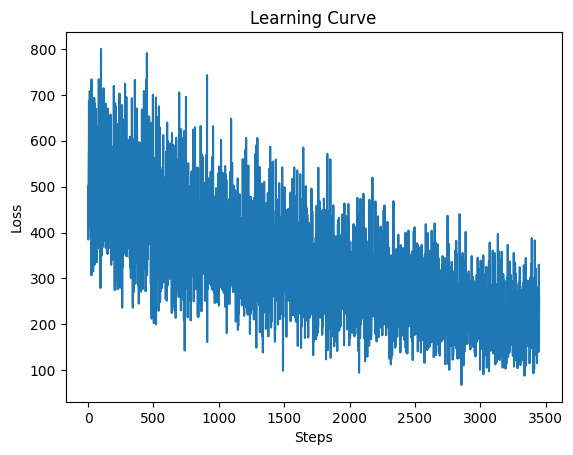

In [6]:
# Vérifiez les données d'entrée
print("X_valid_tensor contains NaN:", torch.isnan(X_valid_tensor).any().item())
print("y_valid_tensor contains NaN:", torch.isnan(y_valid_tensor).any().item())

# Générer les prédictions sur les données de validation
model.eval()
with torch.no_grad():
    y_pred = model(X_valid_tensor).detach().numpy()
    y_pred_train = model(X_train_tensor).detach().numpy()

# Vérifiez les sorties du modèle
print("y_pred contains NaN:", np.isnan(y_pred).any())

# Calculer la MSE
mse = np.mean((y_pred - y_valid_tensor.numpy())**2)
print("MSE :", mse)

# Calculer le t_score
predictions_tensor = torch.tensor(y_pred, dtype=torch.float32)
predictions_tensor_train = torch.tensor(y_pred_train, dtype=torch.float32)
t_score_test = torch.mean((torch.abs(predictions_tensor - y_valid_tensor) <= 5).float())
t_score_train = torch.mean((torch.abs(predictions_tensor_train - y_train_tensor) <= 5).float())
print("t_score test :", t_score_test.item())
print("t_score train :", t_score_train.item())

# Afficher la courbe d'apprentissage
import matplotlib.pyplot as plt
plt.plot(steps, learning_curve)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.show()

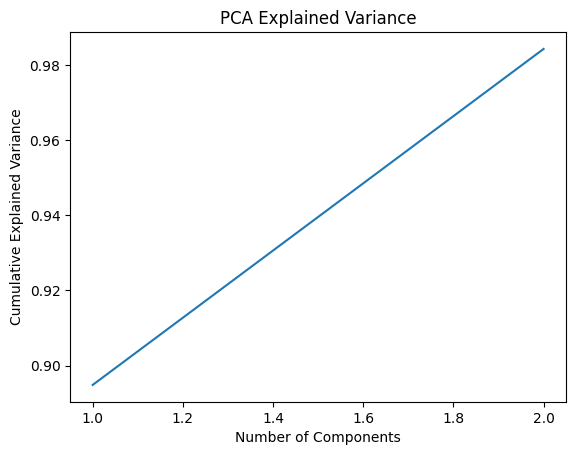

In [7]:
#verification du PCA
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.show()



Nombre de composantes principales nécessaires pour expliquer 95 % de la variance : 2


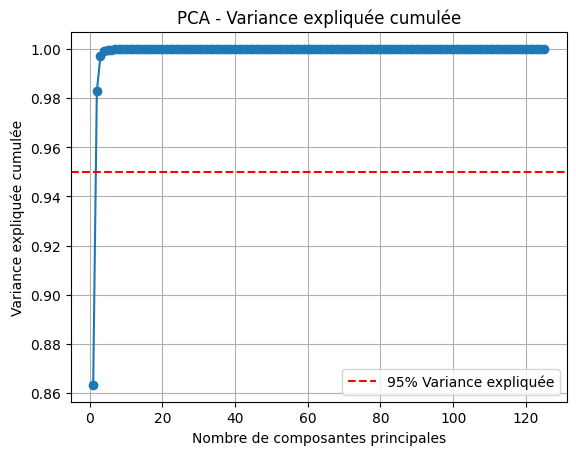

Données après réduction (premières lignes) :
[[-0.47020036 -0.38397127]
 [-0.24741629 -0.05479271]
 [-0.32851501 -0.06350643]
 [ 3.62755916 -0.49541986]
 [ 2.87698151 -0.10442303]]


In [8]:
pca = PCA()

# Apprendre les composantes principales
pca.fit(data.iloc[:, 6:])

# Calculer la variance expliquée cumulée
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Trouver le nombre de composantes nécessaires pour expliquer au moins 95 % de la variance
n_components = np.argmax(explained_variance >= 0.95) + 1
print(f"Nombre de composantes principales nécessaires pour expliquer 95 % de la variance : {n_components}")

# Réduire les données avec le bon nombre de composantes
reduced_data = PCA(n_components=n_components).fit_transform(data.iloc[:, 6:])

# Étape 4 : Visualiser les résultats (optionnel)
import matplotlib.pyplot as plt

plt.plot(np.arange(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance expliquée')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée cumulée')
plt.title('PCA - Variance expliquée cumulée')
plt.legend()
plt.grid()
plt.show()

# Étape 5 : Aperçu des données réduites
print("Données après réduction (premières lignes) :")
print(reduced_data[:5])

In [9]:
print("Composantes principales :")
print(pca.components_)

Composantes principales :
[[ 1.07883324e-01  1.06721199e-01  1.06034258e-01 ...  1.09969508e-01
   1.13010545e-01  1.15436742e-01]
 [ 6.97460619e-02  5.29315982e-02  3.69138838e-02 ...  2.34134863e-01
   2.39548903e-01  2.40324617e-01]
 [ 2.28821967e-01  2.20859709e-01  2.16457205e-01 ...  1.30098205e-01
   1.74771315e-01  2.14272208e-01]
 ...
 [ 8.60015850e-04 -1.10418104e-03  2.14843258e-03 ... -1.77933004e-02
   8.63382187e-03  1.17667226e-04]
 [ 2.01342743e-03 -4.00581210e-03  1.74370303e-03 ...  1.38538795e-02
  -6.32902428e-03  1.16006027e-03]
 [-1.02779098e-03  2.73797049e-03 -1.42351502e-03 ...  2.90839765e-03
  -3.87369469e-03  2.76506121e-03]]
